# Импорт библиотек и чтение датасетов

In [ ]:

import pandas as pd                                                            # модуль для работы с датафреймами

import numpy as np                                                             # модуль для работы с массивами

import matplotlib.pyplot as plt                                                # модуль для визуализации результатов

from catboost import CatBoostRegressor                                         # модуль с моделью CatBoost

from xgboost import XGBRegressor                                               # модуль с моделью XGBoost

from sklearn.neighbors import KNeighborsRegressor                              # модуль с моделью knn

from sklearn.model_selection import TimeSeriesSplit, cross_val_score           # модули с метриками
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV                               # модуль для подбора параметров

from sklearn.preprocessing import StandardScaler                               # модуль для масштабирования данных

from sklearn.decomposition import PCA                                          # метод понижения размерности данных


Загрузка данных

In [98]:
# загрузка данных
train_df = pd.read_excel("data/excel/train.xlsx")
test_df = pd.read_excel("data/excel/test.xlsx")

# логирование
print(f'Размер тренировочной выборки: {train_df.shape}')
print(f'Размер тестовой выборки: {test_df.shape}')


Размер тренировочной выборки: (400, 2)
Размер тестовой выборки: (28, 2)


#### Подготовка данных

Приводим колонку с датой в формат `datetime`

In [99]:
train_df['dt'] = pd.to_datetime(train_df['dt'], dayfirst=True)
test_df['dt'] = pd.to_datetime(test_df['dt'], dayfirst=True)

Для более удобной работы с признаками переименуем колонку с ценой

In [100]:
train_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')
test_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')

Подготовка данных для обучения модели

In [101]:
# объединение данных
combined_df = pd.concat([train_df[['dt', 'Price']], test_df[['dt', 'Price']]]).reset_index(drop=True)
# логирование
print(f'Размер объединенного датасета: {combined_df.shape}')

Размер объединенного датасета: (428, 2)


In [102]:
# установка индекса
combined_df = combined_df.set_index('dt', drop=True)

In [ ]:
# назначение переменных
X = combined_df.drop(columns=['Price']).iloc[:-1, :]
y = combined_df['Price'].values[1:]
X['Price_source'] = combined_df['Price'].values[:-1]
y = y[1:]
X = X.iloc[1:, :]

Разбиение данных на тренировочную и тестовую выборки

In [ ]:
# разделение данных
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [ ]:
# логарифмирование целевой переменной
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)

In [ ]:
# кросс-валидация
tscv = TimeSeriesSplit(n_splits=3)

#### Работа с моделями

Создаем объект с моделью CatBoost

In [ ]:
# параметры модели
model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=3,
    loss_function='MAE',
    early_stopping_rounds=100,
    has_time=True,                    # учитываем временную зависимость
    l2_leaf_reg=10,                   # регуляризация
)
# обучение модели
model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log))

0:	learn: 0.1805126	test: 0.4546041	best: 0.4546041 (0)	total: 829us	remaining: 1.66s
1:	learn: 0.1763067	test: 0.4500345	best: 0.4500345 (1)	total: 1.96ms	remaining: 1.96s
2:	learn: 0.1714869	test: 0.4397550	best: 0.4397550 (2)	total: 2.75ms	remaining: 1.83s
3:	learn: 0.1667218	test: 0.4293496	best: 0.4293496 (3)	total: 3.51ms	remaining: 1.75s
4:	learn: 0.1622306	test: 0.4166096	best: 0.4166096 (4)	total: 4.38ms	remaining: 1.75s
5:	learn: 0.1584968	test: 0.4049026	best: 0.4049026 (5)	total: 5.81ms	remaining: 1.93s
6:	learn: 0.1548592	test: 0.3946446	best: 0.3946446 (6)	total: 8.02ms	remaining: 2.28s
7:	learn: 0.1513554	test: 0.3906612	best: 0.3906612 (7)	total: 9.05ms	remaining: 2.25s
8:	learn: 0.1479741	test: 0.3869497	best: 0.3869497 (8)	total: 10ms	remaining: 2.21s
9:	learn: 0.1446989	test: 0.3780265	best: 0.3780265 (9)	total: 10.9ms	remaining: 2.17s
10:	learn: 0.1414751	test: 0.3744025	best: 0.3744025 (10)	total: 12.1ms	remaining: 2.19s
11:	learn: 0.1389342	test: 0.3708874	best: 0

168:	learn: 0.0238062	test: 0.0384305	best: 0.0384305 (168)	total: 139ms	remaining: 1.51s
169:	learn: 0.0237600	test: 0.0384249	best: 0.0384249 (169)	total: 140ms	remaining: 1.51s
170:	learn: 0.0237298	test: 0.0384157	best: 0.0384157 (170)	total: 141ms	remaining: 1.51s
171:	learn: 0.0236303	test: 0.0383638	best: 0.0383638 (171)	total: 142ms	remaining: 1.51s
172:	learn: 0.0235271	test: 0.0381335	best: 0.0381335 (172)	total: 143ms	remaining: 1.51s
173:	learn: 0.0234533	test: 0.0379920	best: 0.0379920 (173)	total: 144ms	remaining: 1.51s
174:	learn: 0.0234262	test: 0.0379319	best: 0.0379319 (174)	total: 144ms	remaining: 1.5s
175:	learn: 0.0233482	test: 0.0378445	best: 0.0378445 (175)	total: 145ms	remaining: 1.5s
176:	learn: 0.0232542	test: 0.0377723	best: 0.0377723 (176)	total: 145ms	remaining: 1.5s
177:	learn: 0.0232153	test: 0.0376689	best: 0.0376689 (177)	total: 146ms	remaining: 1.49s
178:	learn: 0.0231207	test: 0.0375944	best: 0.0375944 (178)	total: 146ms	remaining: 1.49s
179:	learn: 0

In [ ]:
# метрики
mae_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='r2')

0:	learn: 0.1386080	total: 618us	remaining: 1.24s
1:	learn: 0.1352647	total: 2.6ms	remaining: 2.6s
2:	learn: 0.1319441	total: 3.11ms	remaining: 2.07s
3:	learn: 0.1289265	total: 3.6ms	remaining: 1.8s
4:	learn: 0.1261656	total: 4.14ms	remaining: 1.65s
5:	learn: 0.1236278	total: 4.78ms	remaining: 1.59s
6:	learn: 0.1211353	total: 5.58ms	remaining: 1.59s
7:	learn: 0.1181111	total: 6.28ms	remaining: 1.56s
8:	learn: 0.1153795	total: 7.05ms	remaining: 1.56s
9:	learn: 0.1127714	total: 64.7ms	remaining: 12.9s
10:	learn: 0.1104420	total: 66.7ms	remaining: 12.1s
11:	learn: 0.1076445	total: 71.4ms	remaining: 11.8s
12:	learn: 0.1050596	total: 72.3ms	remaining: 11.1s
13:	learn: 0.1029686	total: 72.8ms	remaining: 10.3s
14:	learn: 0.1007389	total: 73.3ms	remaining: 9.69s
15:	learn: 0.0985698	total: 73.7ms	remaining: 9.13s
16:	learn: 0.0961215	total: 74ms	remaining: 8.63s
17:	learn: 0.0941808	total: 74.6ms	remaining: 8.22s
18:	learn: 0.0922562	total: 76.1ms	remaining: 7.93s
19:	learn: 0.0899692	total: 7

In [ ]:
# предсказание
preds = np.expm1(model.predict(X_test))

# вывод метрик
print(f"R²: {r2_score(y_test, preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
print(f"Средний MAE на кросс-валидации: {-mae_scores.mean():.4f}")
print(f"Средний R² на кросс-валидации: {r2_scores.mean():.4f}")

R²: 0.9317
MAE: 2187.5648
MSE: 8953239.8549
RMSE: 2992.1965
Средний MAE на кросс-валидации: 0.0541
Средний R² на кросс-валидации: 0.7506


Проверка работы модели на графике

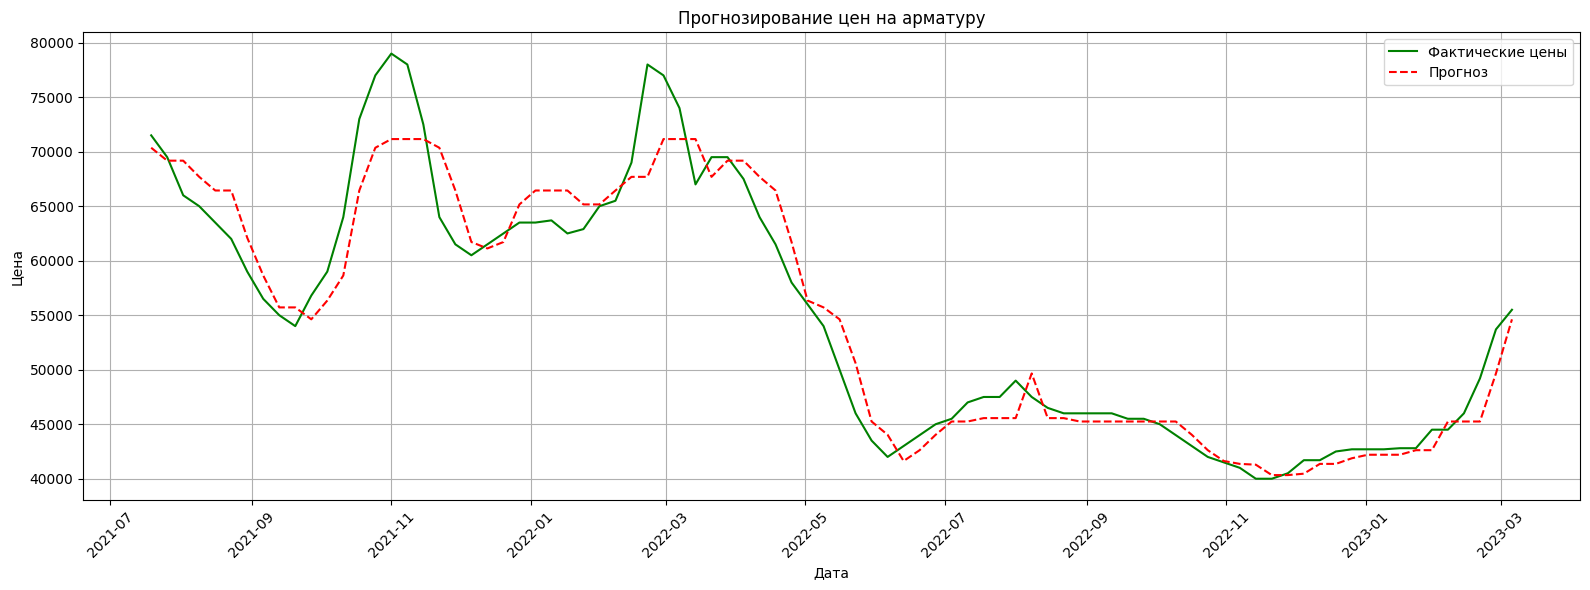

In [ ]:
# визуализация
plt.figure(figsize=(16, 6))
plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
plt.plot(X_test.index, preds, label='Прогноз', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# сохранение модели
model.save_model("catboost_model.cbm")

Модель KNN

In [ ]:


# масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # стандартизация
X_test_scaled = scaler.transform(X_test)        

# понижение размерности с помощью PCA
pca = PCA(n_components=0.95)  # сохраняем 95% вариации в данных
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# модель KNN
knn_model = KNeighborsRegressor()

# подбор гиперпараметров для поиска оптимального числа соседей
param_grid = {
    'n_neighbors': [50, 75, 100, 150],  # пробуем числа соседей
    'weights': ['uniform', 'distance'],  # пробуем разные способы взвешивания
    'algorithm': ['ball_tree', 'kd_tree'],  # используем более быстрые и устойчивые алгоритмы
    'p': [1, 2]  # пробуем различные метрики расстояния (p=1 для Манхэттена, p=2 для Евклида)
}

# GridSearchCV для поиска лучших гиперпараметров
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_absolute_error', verbose=1)
grid_search.fit(X_train_pca, y_train_log)

# лучшие параметры
print("Лучшие гиперпараметры:", grid_search.best_params_)

# обучение модели с лучшими гиперпараметрами
best_knn_model = grid_search.best_estimator_

# предсказания для KNN
knn_preds = np.expm1(best_knn_model.predict(X_test_pca))  # Преобразуем обратно в оригинальную шкалу

# метрики для KNN
print("Метрики для KNN:")
print(f"R²: {r2_score(y_test, knn_preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, knn_preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, knn_preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, knn_preds)):.4f}")


Fitting 5 folds for each of 32 candidates, totalling 160 fits
Лучшие гиперпараметры: {'algorithm': 'kd_tree', 'n_neighbors': 50, 'p': 1, 'weights': 'distance'}
Метрики для KNN:
R²: 0.7952
MAE: 3615.7164
MSE: 26838305.7903
RMSE: 5180.5700


Кросс-валидационный метод обучения ансамбля

In [ ]:

# кросс-валидация
tscv = TimeSeriesSplit(n_splits=3)

# списки для хранения метрик
ensemble_mae_scores = []
ensemble_r2_scores = []
xgb_mae_scores = []
xgb_r2_scores = []
cat_mae_scores = []
cat_r2_scores = []

# проходим по каждому фолду
for fold_idx, (train_index, test_index) in enumerate(tscv.split(X_train)):
    print(f"\nФолд {fold_idx + 1}")
    
    # разделение данных на train и test внутри фолда
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold_log, y_test_fold_log = y_train_log[train_index], y_train_log[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # модель XGBoost
    xgb_model = XGBRegressor(
        n_estimators=2000,
        learning_rate=0.03,
        max_depth=3,
        objective='reg:squarederror',
        reg_lambda=10,
        eval_metric='mae',
    )
    xgb_model.fit(X_train_fold, y_train_fold_log, eval_set=[(X_test_fold, y_test_fold_log)], verbose=False)

    # модель CatBoost
    cat_model = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.03,
        depth=3,
        loss_function='MAE',
        early_stopping_rounds=100,
        l2_leaf_reg=10,
        verbose=False,
    )
    cat_model.fit(X_train_fold, y_train_fold_log, eval_set=(X_test_fold, y_test_fold_log), verbose=False)

    # предсказания XGBoost
    xgb_preds = np.expm1(xgb_model.predict(X_test_fold))

    # предсказания CatBoost
    cat_preds = np.expm1(cat_model.predict(X_test_fold))

    # ансамбль: усреднение предсказаний
    ensemble_preds = (xgb_preds + cat_preds) / 2

    # метрики для ансамбля
    ensemble_mae = mean_absolute_error(y_test_fold, ensemble_preds)
    ensemble_r2 = r2_score(y_test_fold, ensemble_preds)
    ensemble_mae_scores.append(ensemble_mae)
    ensemble_r2_scores.append(ensemble_r2)

    # метрики для XGBoost
    xgb_mae = mean_absolute_error(y_test_fold, xgb_preds)
    xgb_r2 = r2_score(y_test_fold, xgb_preds)
    xgb_mae_scores.append(xgb_mae)
    xgb_r2_scores.append(xgb_r2)

    # метрики для CatBoost
    cat_mae = mean_absolute_error(y_test_fold, cat_preds)
    cat_r2 = r2_score(y_test_fold, cat_preds)
    cat_mae_scores.append(cat_mae)
    cat_r2_scores.append(cat_r2)

    # вывод метрик для текущего фолда
    print(f"Метрики для ансамбля на фолде {fold_idx + 1}:")
    print(f"MAE: {ensemble_mae:.4f}, R²: {ensemble_r2:.4f}")

    print(f"Метрики для XGBoost на фолде {fold_idx + 1}:")
    print(f"MAE: {xgb_mae:.4f}, R²: {xgb_r2:.4f}")

    print(f"Метрики для CatBoost на фолде {fold_idx + 1}:")
    print(f"MAE: {cat_mae:.4f}, R²: {cat_r2:.4f}")

# средние метрики по фолдам
print("\nСредние метрики по всем фолдам:")
print("Ансамбль:")
print(f"Средний MAE: {np.mean(ensemble_mae_scores):.4f}")
print(f"Средний R²: {np.mean(ensemble_r2_scores):.4f}")

print("\nXGBoost:")
print(f"Средний MAE: {np.mean(xgb_mae_scores):.4f}")
print(f"Средний R²: {np.mean(xgb_r2_scores):.4f}")

print("\nCatBoost:")
print(f"Средний MAE: {np.mean(cat_mae_scores):.4f}")
print(f"Средний R²: {np.mean(cat_r2_scores):.4f}")


Фолд 1
Метрики для ансамбля на фолде 1:
MAE: 1081.0089, R²: 0.8203
Метрики для XGBoost на фолде 1:
MAE: 1154.6709, R²: 0.8054
Метрики для CatBoost на фолде 1:
MAE: 1025.2148, R²: 0.8247

Фолд 2
Метрики для ансамбля на фолде 2:
MAE: 952.7566, R²: 0.7903
Метрики для XGBoost на фолде 2:
MAE: 1210.5102, R²: 0.7262
Метрики для CatBoost на фолде 2:
MAE: 836.7725, R²: 0.8013

Фолд 3
Метрики для ансамбля на фолде 3:
MAE: 5401.7393, R²: 0.5187
Метрики для XGBoost на фолде 3:
MAE: 5433.7473, R²: 0.5193
Метрики для CatBoost на фолде 3:
MAE: 5375.7131, R²: 0.5175

Средние метрики по всем фолдам:
Ансамбль:
Средний MAE: 2478.5016
Средний R²: 0.7098

XGBoost:
Средний MAE: 2599.6428
Средний R²: 0.6836

CatBoost:
Средний MAE: 2412.5668
Средний R²: 0.7145


Обучение ансамбля без кросс-валидации

In [114]:

# Модель XGBoost
xgb_model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=3,
    objective='reg:squarederror',
    reg_lambda=10,
    eval_metric='mae',
)

# Модель CatBoost
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=3,
    loss_function='MAE',
    early_stopping_rounds=100,
    l2_leaf_reg=10,
    verbose=False,  
)

# Обучение XGBoost
xgb_model.fit(X_train, y_train_log, eval_set=[(X_test, y_test_log)], verbose=False)

# Обучение CatBoost
cat_model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log), verbose=False)

# Предсказания XGBoost
xgb_preds = np.expm1(xgb_model.predict(X_test))

# Предсказания CatBoost
cat_preds = np.expm1(cat_model.predict(X_test))

# Ансамбль: усреднение предсказаний
ensemble_preds = (xgb_preds + cat_preds) / 2

# Метрики для ансамбля
print("Метрики для ансамбля:")
print(f"R²: {r2_score(y_test, ensemble_preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, ensemble_preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, ensemble_preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, ensemble_preds)):.4f}")

# Метрики для XGBoost
print("\nМетрики для XGBoost:")
print(f"R²: {r2_score(y_test, xgb_preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, xgb_preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, xgb_preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, xgb_preds)):.4f}")

# Метрики для CatBoost
print("\nМетрики для CatBoost:")
print(f"R²: {r2_score(y_test, cat_preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, cat_preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, cat_preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, cat_preds)):.4f}")

Метрики для ансамбля:
R²: 0.9295
MAE: 2311.2493
MSE: 9242205.5581
RMSE: 3040.0996

Метрики для XGBoost:
R²: 0.9130
MAE: 2663.5612
MSE: 11396711.9874
RMSE: 3375.9017

Метрики для CatBoost:
R²: 0.9317
MAE: 2187.5648
MSE: 8953239.8549
RMSE: 2992.1965
